In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
import numpy as np

# Homework 4 - Feature Descriptors

In [2]:
# helper functions

image_link_1 = "https://github.com/Avinash793/panoramic-image-stitching/blob/master/inputs/tajm4.jpg?raw=true"
image_link_2 = "https://github.com/Avinash793/panoramic-image-stitching/blob/master/inputs/tajm1.jpg?raw=true"


def download_image(image_link: str, image_name: str) -> str:
    # Download the image and save it locally as a .jpg file
    response = requests.get(image_link)
    local_filename = image_name
    with open(local_filename, "wb") as f:
        f.write(response.content)
    return local_filename

## Exercise 1

## Overview
Implement the function `exercise_1` that detects and matches SIFT features between two images.
This will allow to create a following algorithm:
1. Find keypoints and descriptors for both images
   (while you already know what keypoints are, the descriptors are some features that will allow you to match keypoints between images, feel free to read up on SIFT to get more information)
2. Use the cv.FlannBasedMatcher to find the best matches between descriptors of both images
3. Return the keypoints and the matches
4. Draw the matches on the images and display them

In [3]:
def exercise_1(img1: np.ndarray, img2: np.ndarray) -> tuple:
    """
    Detect and match SIFT features between two images.

    1. Find keypoints and descriptors for both images
    2. Use cv.FlannBasedMatcher to find the best matches
    3. Apply the ratio test (as described by David Lowe, feel free to google it, with threshold 0.6)
    4. Return the keypoints and the matches that pass the ratio test

    :param img1: First input image
    :param img2: Second input image
    :returns: Tuple containing (keypoints1, keypoints2, matches)
        Hint: look at the arguments of cv2.drawMatches to figure out how to return the matches
    """
    # <your_code_here>
    #convert images to grayscale
    img1gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    #use sift to find keypoints and descriptors for both images
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1gray, None)
    kp2, des2 = sift.detectAndCompute(img2gray, None)
    #use flann to find the best matches between descriptors of both images
    #adjust number of trees and checks to get better results
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=32)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)
    #apply the ratio test and return list of matches as expected by the function cv2.drawMatches
    matches = [d1 for d1, d2 in matches if d1.distance < 0.6 * d2.distance]
        # </your_code_here>

    return kp1, kp2, matches


[< cv2.DMatch 0x11d61aa90>, < cv2.DMatch 0x11d6dcd90>, < cv2.DMatch 0x11d6dd090>, < cv2.DMatch 0x11d6dfb90>, < cv2.DMatch 0x11d6dfd50>, < cv2.DMatch 0x11d6dfd90>, < cv2.DMatch 0x11d6dff90>, < cv2.DMatch 0x11d6e18d0>, < cv2.DMatch 0x11d6e4e50>, < cv2.DMatch 0x11d6e6090>, < cv2.DMatch 0x11d6e6d50>, < cv2.DMatch 0x11d6e8890>, < cv2.DMatch 0x11d6e8e10>, < cv2.DMatch 0x11d6ea350>, < cv2.DMatch 0x11d6ec390>, < cv2.DMatch 0x11f24a450>, < cv2.DMatch 0x11f24af50>, < cv2.DMatch 0x11f252090>, < cv2.DMatch 0x11f252650>, < cv2.DMatch 0x11f252690>, < cv2.DMatch 0x11f252a50>, < cv2.DMatch 0x11f256050>, < cv2.DMatch 0x11f258c50>, < cv2.DMatch 0x11f25aed0>, < cv2.DMatch 0x11f25c5d0>, < cv2.DMatch 0x11f25ccd0>, < cv2.DMatch 0x11f25e310>, < cv2.DMatch 0x11f25ed90>, < cv2.DMatch 0x11f26e390>, < cv2.DMatch 0x11f2769d0>]


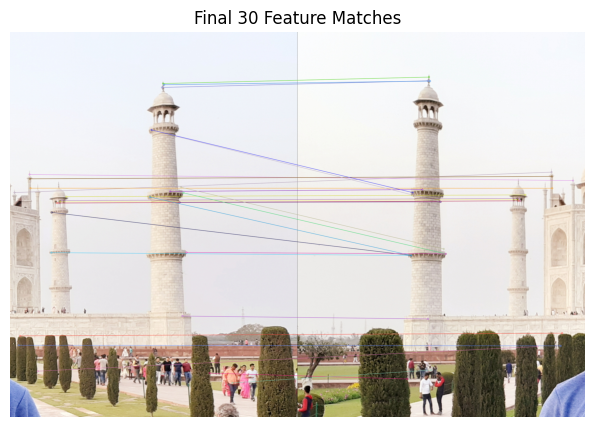

In [4]:
img1 = cv2.imread(download_image(image_link_1, "image1.jpg"))
img2 = cv2.imread(download_image(image_link_2, "image2.jpg"))
# reshape img 1 to im 2
img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))
# Detect and match features
kp1, kp2, final_matches = exercise_1(img1, img2)
print(final_matches)
img_matches = cv2.drawMatches(
    img1,
    kp1,
    img2,
    kp2,
    final_matches,
    None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
)


# Plot the feature matches
plt.figure(figsize=(15, 5))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.title(f"Final {len(final_matches)} Feature Matches")
plt.axis("off")
plt.show()

## Exercise 2

0
2
3
4


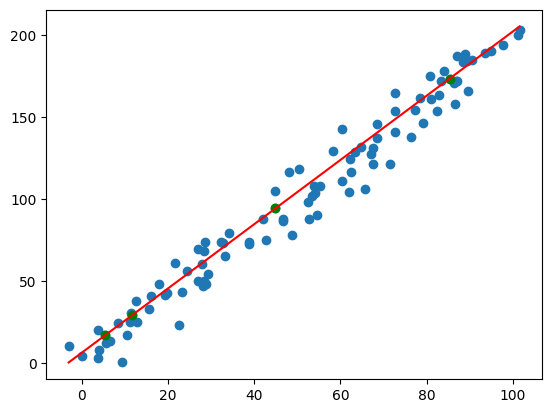

In [60]:
def exercise_2(
    points: np.ndarray,
    num_iter: int,
    threshold: float,
) -> tuple[tuple[float, float], np.ndarray]:
    """
    Implement RANSAC algorithm to fit a line to 2D points.
    1. Feel free to implement it the way you like it, just do not use cv2.RANSAC :)
    2. Setting the threshold will depend on your implementation, feel free to experiment with it
    
    :param points: Input points as Nx2 numpy array
    :param num_iter: Number of RANSAC iterations
    :param threshold: Distance threshold for inlier classification
    :returns: Tuple containing (best_model, best_inliers), where 
        - best_model is a tuple (a, b) defining the best-fit line y = ax + b
        - best_inliers is a Mx2 numpy array containing the inliers that best model has explained (M << N)
    """
    # <your_code_here>
    
    best_model, best_inliers = None, np.empty((0, 0))
    #iterate over num_iter iterations
    for i in range(num_iter): 
        #randomly select 2 points
        x1, x2 = np.random.choice(points.shape[0], size=2, replace=False)
        p1, p2 = points[x1], points[x2]
        #calculate the line equation
        a = (p2[1] - p1[1]) / (p2[0] - p1[0])
        b = p1[1] - a * p1[0]
        #find inliers
        inliers = []
        for point in points:
            x, y = point
            #calculate the distance of the point from the line
            distance = np.abs(y-(a*x+b)) / np.sqrt(a**2+1)
            if distance < threshold:
                inliers.append(point)
        #if the number of inliers is greater than the number of best_inliers, update the best_model and best_inliers
        if len(inliers) > len(best_inliers):
            best_model = (a, b)
            best_inliers = np.array(inliers)
    # </your_code_here>

    return best_model, best_inliers

# the "secret"line that we want to fit (y = ax + b)
line = np.array([2, 1])
# create a dataset of 100 points that are sampled from the line y = ax + b
# add some noise to the points
points = np.array(
    [
        np.array([x, line[0] * x + line[1]]) + np.random.randn(2) * 5.0
        for x in range(100)
    ]
)
best_model, inliers = exercise_2(points, num_iter=10, threshold=0.1)

# a is the slope, b is the intercept (y = ax + b)
a, b = best_model
# inliers is a numpy array of the inliers (Nx2)
x = np.array([points[:, 0].min(), points[:, 0].max()])
y = a * x + b
plt.scatter(points[:, 0], points[:, 1])
plt.scatter(inliers[:, 0], inliers[:, 1], color="green")
plt.plot(x, y, color="red")
plt.show()